# 3D Conformation Prediction

In [26]:
import pandas as pd
import numpy as np
import os
import glob
import torch
import torch.nn.functional as F
from tqdm import tqdm
from rdkit.Chem import MolFromSmiles

In [4]:
from IPython import get_ipython

def tqdm_clear(*args, **kwargs):
    from tqdm import tqdm
    getattr(tqdm, '_instances', {}).clear()

get_ipython().events.register('post_execute', tqdm_clear)

## Load QM9

In [266]:
file_re = os.path.join('./qm92', '*.xyz')
file_pathes = glob.glob(file_re)
file_pathes.sort()
ls = []
_smiles_column_names = ['smiles1', 'smiles2']
_label_names = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
                'zpve', 'U0', 'U', 'H', 'G', 'Cv']

y = []
for ix,path in enumerate(tqdm(file_pathes)):
    with open(path, 'r') as f:
        data = [line.strip() for line in f]
        
    num_atom = int(data[0])
    # We're only interested in molecules with 3 or more molecules
    if num_atom < 3:
        continue
    properties = list(map(float, data[1].split('\t')[1:]))
    ys = []
    for ix_pos in range(2,num_atom+2):
        if not data[ix_pos][0] == 'H':
            ys.append(list(map(float, data[ix_pos].replace('*^', 'e').split('\t')[1:]))[:3])

    if len(ys) < 3:
        continue
    y.append(ys)

    smiles = data[3 + num_atom].split('\t')
    new_ls = smiles + properties
    ls.append(new_ls)

df = pd.DataFrame(ls, columns= _smiles_column_names + _label_names)

100%|██████████| 133885/133885 [00:06<00:00, 21960.38it/s]


In [267]:
df.sample(5)

,smiles1,smiles2,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
45298,O=C1CC2CC=CC2C1,O=C1C[C@H]2CC=C[C@H]2C1,3.31286,1.34376,1.14366,2.7623,79.27,-0.2322,-0.0147,0.2175,1106.2775,0.161258,-385.938483,-385.930940,-385.929995,-385.971991,29.480
20224,C1CC2C3C4C3C2C14,C1C[C@H]2[C@H]3[C@@H]4[C@H]3[C@H]2[C@H]14,4.01041,2.57927,2.20695,0.0631,72.80,-0.2344,0.0938,0.3282,707.8651,0.157769,-310.631478,-310.625972,-310.625028,-310.660707,23.915
38013,C1C2N=C3NC=NC3C12,C1[C@H]2[N][C]3N[CH][N][C@H]3[C@@H]12,3.69526,1.72923,1.37521,1.0729,72.75,-0.2263,-0.0101,0.2162,915.8435,0.128583,-396.926344,-396.920135,-396.919191,-396.956727,25.670
111910,CC1OC(N)=NC1CO,C[C@H]1O[C](N)[N][C@H]1CO,2.12607,1.47993,0.95983,3.4386,72.82,-0.2254,0.0471,0.2725,1240.8898,0.160257,-456.370900,-456.361779,-456.360834,-456.404992,34.188
115618,CN1CC11CCC1CO,CN1C[C@]21CC[C@H]2CO,2.71760,1.10942,0.97126,1.2227,83.02,-0.2245,0.0785,0.3030,1338.3809,0.193059,-404.299637,-404.289850,-404.288906,-404.334566,36.282


# Setting up dataset

The first thing we want to do is to find a way of representing a molecule to our graph convolutional network. For this, we will make use of DeepChem which provides a number of 'featurizers'. In this case the features of an atom is a number of descriptors generated from RDKit.

In [320]:
mols = [MolFromSmiles(row.smiles1) for (ix,row) in df.iterrows()]

### Adding Fingerprints to the mix

In [321]:
from rdkit.Chem import AllChem
fingerprints = []
for m in mols:
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m, useChirality=True, radius=2, nBits=1024)
    vec1 = np.array(fp1);
    fingerprints.append(vec1)

### Looking at some 2D representations

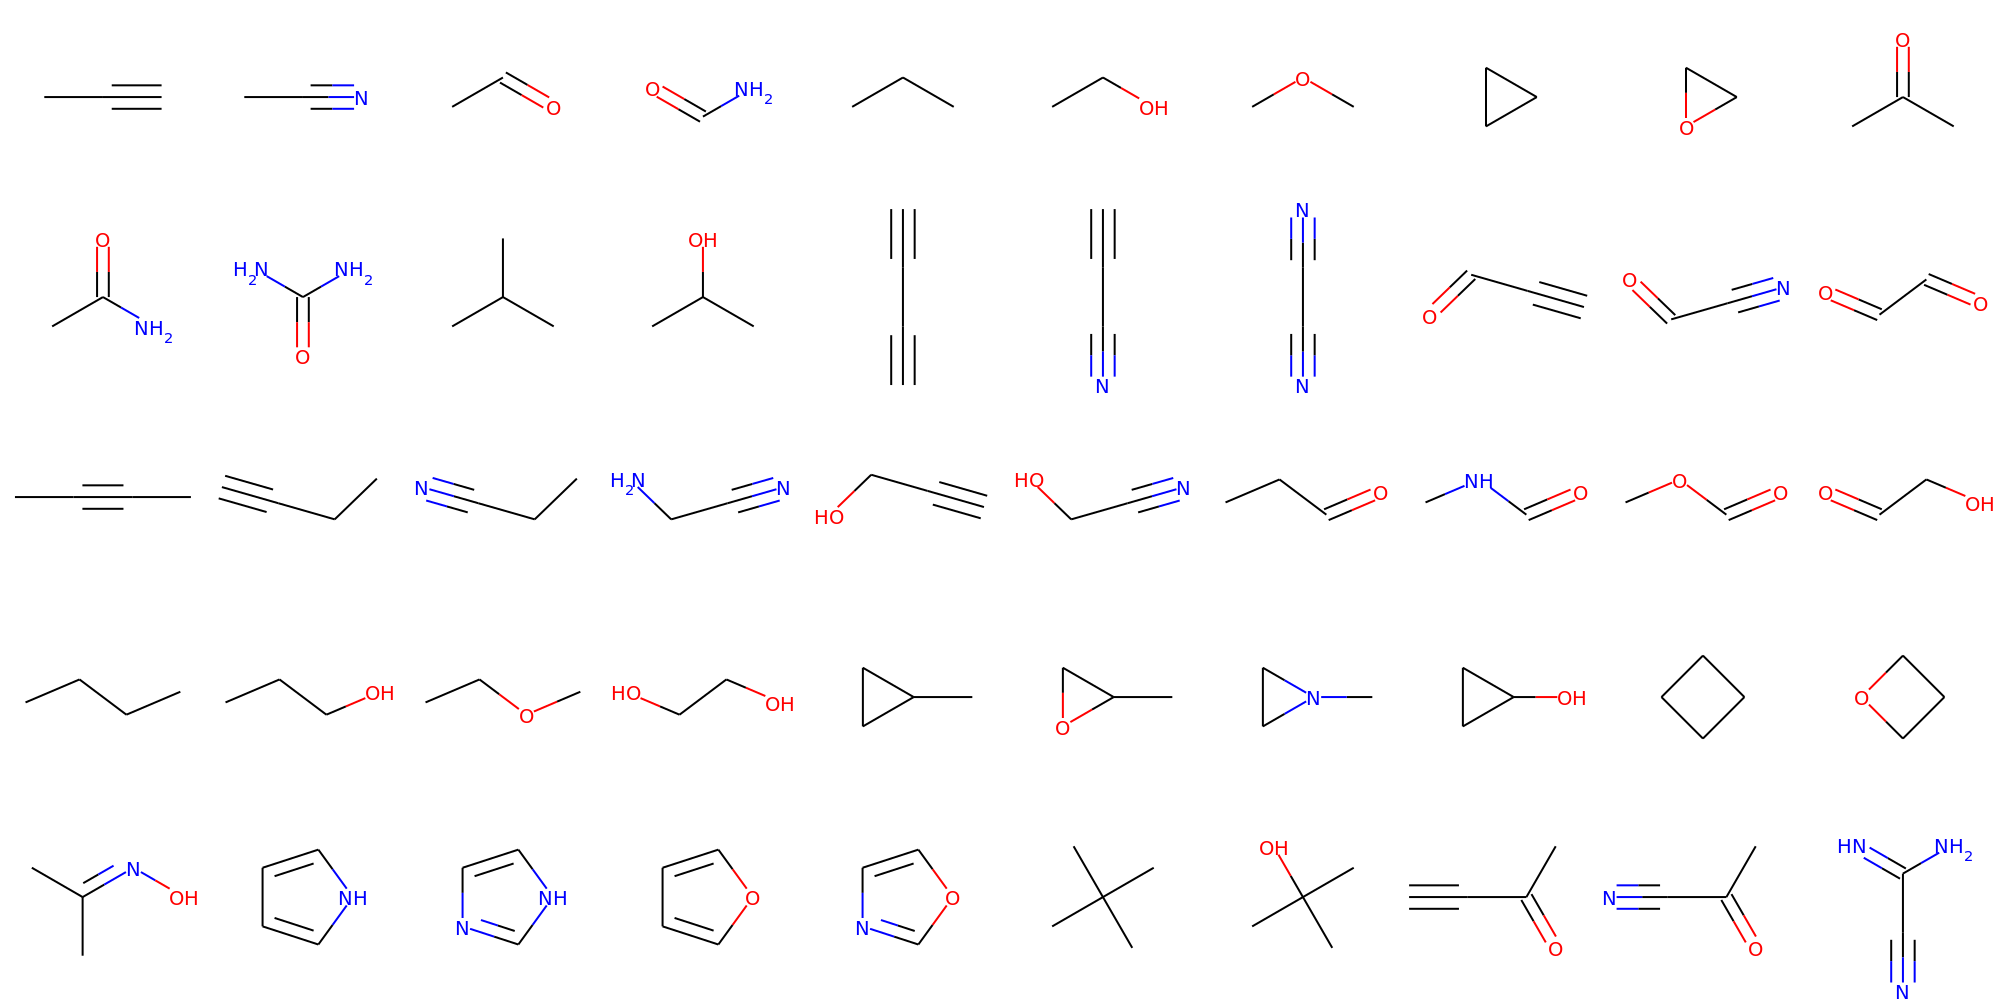

In [319]:
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole
img = Draw.MolsToGridImage( mols[:50], molsPerRow=10)
img

### Looking at graph representations

In [72]:
import networkx as nx

def create_edge_index(A):
    rows = []
    cols = []
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                rows.append(i)
                cols.append(j)
    return rows, cols

def get_molecule_features(m):
    featurizer = ConvMolFeaturizer()
    return featurizer.featurize([m])[0].get_atom_features()

In [315]:
from deepchem.feat import RDKitDescriptors, ConvMolFeaturizer
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

m = mols[10]
molecule_featurized = get_molecule_features(m)
A = GetAdjacencyMatrix(m)

In [316]:
atomlist = [at.GetSymbol() for at in m.GetAtoms()]
atomlist

['C', 'C', 'N', 'O']

Let's see how our adjacency matrix looks. This matrix will be used in our graph convolutions.

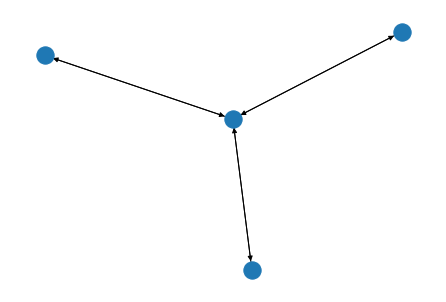

In [336]:
D = nx.to_networkx_graph(A,create_using=nx.DiGraph())
nx.draw(D)

Let's see how the molecule looks in 2D according to RDKit

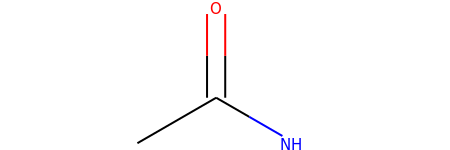

In [318]:
m

Let's repeat this for all molecules

In [10]:
import os.path
import pickle
from torch_geometric.data import Data, DataLoader
from torchvision import transforms
fname = 'data_list.pickle'

if not os.path.isfile(fname) :
    data_list = []
    for ix, m in enumerate(mols):
        mol_featurized = get_molecule_features(m)
        A = GetAdjacencyMatrix(m)
        edge_index = create_edge_index(A)
        x = torch.tensor(mol_featurized)
        #x_min = torch.min(x)
        #range_x = torch.max(x) - torch.min(x)
        #x = (x - x_min) / range_x
        if not x.shape[0] == torch.DoubleTensor(y[ix]).shape[0]:
            print("Unmatching x and y!")
            print(x.shape)
            print(torch.DoubleTensor(y[ix]).shape)
            break
        d = Data(x=x, edge_index=torch.LongTensor(edge_index), y=torch.DoubleTensor(y[ix]))
        d.fingerprint = fingerprints[ix]
        d.atom_list = [at.GetSymbol() for at in m.GetAtoms()]
        data_list.append(d)
        
    with open(fname, 'wb') as f:
        pickle.dump(data_list, f)
else:
    with open(fname, 'rb') as f:
        data_list = pickle.load(f)

In [11]:
loader = DataLoader(data_list, batch_size=32)

# Setting Up Graph Convolutional Network

In [12]:
from torch_geometric.nn import GCNConv, BatchNorm, GMMConv, SAGEConv, GraphConv, GATConv
from torch_geometric.nn.pool import TopKPooling, EdgePooling, SAGPooling
from torch import nn

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GraphConv(75, 256)
        self.conv2 = GraphConv(256, 256)
        self.batch_norm1 = BatchNorm(256)
        self.linear = nn.Linear(256, 128)
        self.linear2 = nn.Linear(1152, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.linear(x)
        
        outs = []
        fp = torch.DoubleTensor(data.fingerprint).to(device)
        for row_ix in range(x.shape[0]):
            z = torch.cat((x[row_ix,:], fp), 0)
            outs.append(self.linear2(z))
        
        return torch.stack(outs)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = loader.dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [14]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [15]:
#import random
#random.shuffle(loader.dataset)
N = len(loader.dataset)
num_train = 100000
X_train = loader.dataset[:num_train]
X_val = loader.dataset[num_train:num_train+20000]
batch_size = 128
X_train_batched = chunks(X_train, len(X_train) // batch_size)
model.double()

Net(
  (conv1): GraphConv(75, 256)
  (conv2): GraphConv(256, 256)
  (batch_norm1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=1152, out_features=3, bias=True)
)

In [ ]:
model.train()
n_epochs = 10
saving_freq = 1

for epoch in range(n_epochs):
    model.train()
    print("===== Epoch %d of %d ====" % (epoch + 1, n_epochs))
    losses = []
    batch_ix = 0
    num_batches = len(X_train) // batch_size
    random.shuffle(X_train)
    val_loss = 0
    X_train_batched = chunks(X_train, num_batches)
    for batch_ix in tqdm(range(num_batches)):
        print(X_train_batched)
        batch = next(X_train_batched)
        y_hats = []
        ys = []

        for data in batch:
            data.to(device)
            y_hat = model(data)
            y_hats.append(y_hat)
            ys.append(data.y)
            

        y_hats = torch.cat(y_hats)
        ys = torch.cat(ys)

        loss = F.mse_loss(y_hats, ys)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()
     
   
    with torch.no_grad():
        y_hats = []
        ys = []
        
        print("Validation")
        model.eval()
        
        for data in tqdm(X_val):
            data.to(device)
            y_hat = model(data)
            y_hats.append(y_hat)
            ys.append(data.y)
            
        y_hats = torch.cat(y_hats)
        ys = torch.cat(ys)
        
        loss = F.mse_loss(y_hats, ys)
        val_loss = loss.mean()
        
    if epoch % saving_freq == 0:
        torch.save(model.state_dict(), './saved_model/model_%d' % epoch )
   
    
    print("Training loss: %.4f" % torch.stack(losses).mean())
    print("Validation loss: %.4f" % val_loss)

torch.save(model.state_dict(), './model_latest')

In [16]:
import ase
import pandas as pd
import numpy as np
from ase import Atoms
import ase.visualize
import random

In [17]:
model.load_state_dict(torch.load('./model_latest'))
model.eval()

Net(
  (conv1): GraphConv(75, 256)
  (conv2): GraphConv(256, 256)
  (batch_norm1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=1152, out_features=3, bias=True)
)

In [322]:
curr_mol = 10

In [323]:
x_0 = X_train[curr_mol]
x_0.to(device)
with torch.no_grad():
    y_0_hat = model(x_0)
    y_0 = x_0.y.cpu().numpy()
    
#system = Atoms(positions=y_0_hat.cpu().numpy(), symbols=x_0.atom_list)
#ase.visualize.view(system, viewer="x3d")

system = Atoms(positions=y_0, symbols=x_0.atom_list)
ase.visualize.view(system, viewer="ngl")

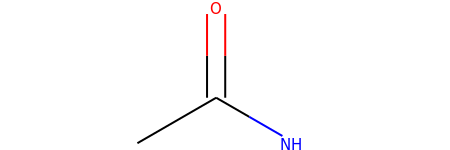

In [324]:
mols[curr_mol].GetNumAtoms()
mols[curr_mol]

In [326]:
system = Atoms(positions=y_0_hat.cpu().numpy(), symbols=x_0.atom_list)
ase.visualize.view(system, viewer="ngl")